Nous avons d'abord essayé de créer une base de données grâce à l'API Spotify. Cette base de données ne sera pas utilisée ensuite pour la modélisation, en effet du jour au lendemain, fin novembre, l'API Spotify a restreint l'accès à certaines données clés pour notre projet et ceci avant que notre projet ne soit finalisé, d'où la nécessité en partie II d'utiliser une base de données Kaggle.

# Introduction

Ce notebook présente une approche pour déterminer le genre d'une musique à travers les caractéristiques fournies par l'API spotify en utilisant des algorithmes de Machine Learning. Il s'agit d'une version simplifiée du notebook `final_nootebook` dans lequel les fonctions utilisées ne sont pas détayées mais stockées dans utils. Les hyperparamètres des modèles ont également état optimisés. Ce projet s'intègre dans le cadre du cours Python pour la Data Science de l'ENSAE Paris. Il a été mené par Tom Laflotte, Enzo Moran et Martin Conte.

Il suit le plan suivant:

I. Une première approche via l'API Spotify

1. Collecte des données

    a. Constitution d'un premier dataset
    
    b. Collecte du genre des artistes

2. Visualisation

II. Prédiction à l'aide d'une base de données Kaggle 

1. Préparation des données

    a. Gestion des valeurs

    b. Standardisation des variables continues

    c. Imputation des valeur manquantes

    d. Imputation des variables catégorielles *

2. Visualisation des données préparées

    a. Analyse multivariée

    b.Vérification du poids des variables

3. Modélisation

    a. Random Forest

    b. XGBoost

    c. Catboost

Conclusion





In [ ]:
!pip install spotipy
!pip install numpy==1.26.4
!pip install catboost

In [12]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import csv
import time
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    validation_curve,
)
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    recall_score,
    f1_score,
    zero_one_loss,
    classification_report,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from pprint import pprint

# I. Une première approche via l'API Spotify

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

## I.1. Collecte des données

Nous avons d'abord essayé de créer une base de données grâce à l'API Spotify.

### I.1.a. Constitution d'un premier dataset

Spotify ne met pas à disposition une quelconque base de donnée déjà constituée. Nous allons donc devoir faire des requêtes successives à l'API pour récolter les informations sur les morceaux choisis, afin de constituer notre premier dataset. Chaque requête permet d'obtenir les metadonnées d'un artiste donné, ou d'une playlist donnée. C'est ce que nous avons choisi de faire.

Pour minimiser le nombre de requêtes, nous sélectionnons une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist_id. Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceau : les track features, qui sont un tas d'indices quantitatifs Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau. C'est ici une limite préoccupante : le genre qui est la variable à prédire n'est en fait que le genre de l'artiste et pas le genre véritable du morceau.

D'abord, on initialise le client Spotify pour l'obtention des données via l'API grâce au token d'accès.

In [4]:
def spotify_client():
    """
    Initilaise le client de l'API Spotify 
    Retourne un client Spotify authentifié
    """
    return spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id="d666ee3ae4c94b85945c3dba39776f4f",
        client_secret="c1973a77acbe48c0b2f105e4f57d7d46" 
    ))

Ensuite, nous utilisons ce client pour notre requête sur la playlist de 10 000 morceaux.

Nous entrons l'id de la playlist en question. Nous récupérons les informations de la playlist relatives aux morceaux dans get_all_playlist_tracks. Avec les informations obtenues précédemment, nous créons avec get_track_id_and_artist un dataframe qui pour chaque morceau de la playlist en donne le titre, l'id, l'artist, l'artist id.

Notre objectif final est d'obtenir un fichier csv compilant toutes les données fournies par l'API de Spotify dans un fichier csv.
Voici la fonction réalisant cette tache :

In [5]:
def get_playlists_data_to_csv(playlist_ids):
    """This function allows to fetch the data from different playlists into a csv
    Params:
        - playlist_ids: a list of playlists we want to fetch our data from
    """
    names=[]
    track_data=[]
    file_name=''
    for playlist in playlist_ids: 
        print(f"Fetching playlist {playlist} tracks...")
        tracks = fetch_playlist_tracks(playlist)
        print("Fetching track data...")
        track_data+=(fetch_track_data(tracks))
    for id in playlist_ids:
        names.append(spotify_client().playlist(id)['name'])
    for name in names:
        file_name+=name+'+'
    file_name=file_name[:-1]
    print(file_name)
    if track_data:
        save_to_csv(track_data, f"playlists_{file_name}_data.csv")
    else:
        print("No data to save.")

Détaillons cette fonction, la fonction fetch_playlist_tracks est définie ci-dessous permet l'obtention d'informations identifiant l'ensemble des musiques d'une playlist.

In [6]:
def fetch_playlist_tracks(playlist_id):
    """
    Fetch all tracks from a Spotify playlist. 
    Params:
        -playlist_id: Spotify playlist ID.
    Returns a list of dictionaries containing track details.
    """
    tracks = []
    results = spotify_client().playlist_tracks(playlist_id)
    while results:
        for item in results['items']:
            track = item['track']
            if track:  # Ensure the track is not None
                tracks.append(track)
        results = spotify_client().next(results) if results['next'] else None
    return tracks

Il faut également obtenir le genre de l'artiste que nous assimilerons dans un premier temps à celui de la musique. Ici, nous ne sélectionnons que le genre principal de l'artiste pour plus de simplicité

In [7]:
def fetch_artist_genre(track):
    """This function fetches the genre of an artist with a track from this artist, it will be 
    considerated as the genre of the song later

    Args:
        track a dict the countains infos about the track

    Returns: genre a string that is the genre of an artist
        
    """
    artist=track['artists'][0]['id']
    if spotify_client().artist(artist)['genres'] != []:
        return spotify_client().artist(artist)['genres'][0]
    else:
        return 'N/A'

On peut alors obtenir l'ensemble des informations relatives à chaque musique utiles à l'analyse (dansabilité, tempo...) via la fonction `fetch_track_data`. Du fait des restrictions de requêtes imposées par l'API de spotify, nous avons mis en place des requêtes par paquets de 100 chansons suivi d'une pause d'une minute, cette approche nous a permis de constituer une première base de données de 1500 musiques, en répétant ce procédé sur une plus longue période, il serait possible d'obtenir les données de l'ensemble de la playlist mais comme nous le détaillerons plus tard, nous n'avons pas retenu cette approche et nous contenterons de la base de données intermédiaire.

In [8]:
def fetch_track_data(tracks):
    """
    Fetch metadata and audio features for each track in the playlist.
    Params:
        -tracks: List of tracks from the playlist.
    Returns a list of dictionaries containing track metadata and audio features.
    """
    track_data = []
    i=0
    j=0
    for track in tracks:
        track_id = track['id']
        i+=1
        print(i)
        audio_features = spotify_client().audio_features([track_id])[0]
        genre=fetch_artist_genre(track)
        if audio_features: 
            artist_name = ", ".join([artist['name'] for artist in track['artists']])
            dict_track={"track Name": track['name'],
                "artists": artist_name,
                "track_id": track_id,
                "popularity": track['popularity'],
                "duration_ms": track['duration_ms'],
                "explicit": track['explicit'], 'genre': genre}
            for key in audio_features.keys():
                dict_track[key]=audio_features[key]
            track_data.append(dict_track)
        if i==100:
            j+=1
            save_to_csv(track_data, f"intermédiaire{j}")
            i=0
            time.sleep(60)
    return track_data


Il ne reste plus qu'à sauvegarder le tout au format csv: 

In [9]:
def save_to_csv(data, filename):
    """
    Save the list of track data to a CSV file.
    Params:
    :param data: List of dictionaries containing track details.
    :param filename: Output CSV file name.
    """
    keys = data[0].keys() if data else []
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)
    print(f"Data saved to {filename}")


La requête suivante permet de constituer un premier dataset consitué des musiques de la playlist "Top 10 000 songs of All-Time":

In [ ]:
#get_playlists_data_to_csv(['1G8IpkZKobrIlXcVPoSIuf'])#

### I.1.b. Collecte du genre de la playlist

Nous avons réussi à enregistrer une première version de notre df que nous visualiserons en partie I. 2. Cependant, cette approche ne nous donne que le genre de l'artiste et pas nécessairement de la playlist. C'est pourquoi nous avons décidé d'adapter certaines de nos fonctions afin de collecter le genre des playlists et de collecter les données de playlists aux genres spécifiques. Le genre de la playlist sera ensuite assimilé à celui de l'artiste. A cet effet, nous avons ajouté la fonction get_playlist_data_to_csv_with_genre

In [11]:
def get_playlists_data_to_csv_with_genre(playlist_ids):
    """This function allows to fetch the data from different playlists into a csv 
    Params:
        - playlist_ids: a dict whose keys are genres and values are playlists (strings)
    """
    names=[]
    track_data=[]
    file_name=''
    for key in playlist_ids.keys(): 
        print(f"Fetching playlist {playlist_ids[key]} tracks...")
        tracks = fetch_playlist_tracks(playlist_ids[key])
        print("Fetching track data...")
        track_data+=(fetch_track_data_without_genre(tracks, key))
    for key1 in playlist_ids.keys():
        names.append(spotify_client().playlist(playlist_ids[key1])['name'])
    for name in names:
        file_name+=name+'+'
    file_name=file_name[:-1]
    print(file_name)
    if track_data:
        save_to_csv(track_data, f"playlists_{file_name}_data.csv")

Détaillons les fonctions appelées par cette fonction.fetch_track_data_without_genre permet d'obtenir les données d'une liste de chansons dont le genre est déjà connu

In [ ]:
def fetch_track_data_without_genre(tracks,genre):
    """
    Fetch metadata and audio features for each track in the playlist knowing the genre of the playlist
    Params:
        -tracks: List of tracks from the playlist.
    Returns a list of dictionaries containing track metadata and audio features.
    """
    track_data = []
    i=0
    for track in tracks:
        track_id = track['id']
        i+=1
        audio_features = spotify_client().audio_features([track_id])[0]
        if audio_features:  # Ensure audio features are available
            artist_name = ", ".join([artist['name'] for artist in track['artists']])
            dict_track={"track Name": track['name'],
                "artists": artist_name,
                "track_id": track_id,
                "popularity": track['popularity'],
                "duration_ms": track['duration_ms'],
                "explicit": track['explicit'], 'genre': genre}
            for key in audio_features.keys():
                dict_track[key]=audio_features[key]
            track_data.append(dict_track)
        if i==100:
            j+=1
            save_to_csv(track_data, f"intermédiaire_realdb{j}")
            i=0
            time.sleep(60)
    return track_data

Le genre est déjà connu car il s'agit de la clé utilisée lors des requêtes faites à la fonction get_playlist_data_to_csv_with_genre. Voici un exemple de requête:

In [ ]:
#get_playlists_data_to_csv_with_genre({'rap' : '4KsrGBWG6gzBwGe9dx16OE', 
#                                      'country' : '33mU9g6y8nKFAOyiISor0G',
#                                      'blues' : '7BDUphylF8dfPKFo9Tvdr9',
#                                      'metal' : '1yYEy4MtNLVScj74wcPR7w',
#                                      'r_and_b' : '7CI3NR7rvCkgiLhch1qprf',
#                                      'classical_music' : '5n9btvMZ52rxwozhQdKU7v',
#                                      'jazz' : '79Bcltku1dcD08JcAM29kL',
#                                      'pop' : '7gqtGYFoCR3tAqTtEUQZTw'})

Cette deuxième approche nous aurait permis de constituer un dataset plus précis mais nous n'avons pas pu la mettre en place. En effet, les conditions d'utilisation de l'API spotify ont été changées et il n'est plus possible de faire des requêtes donnant accès aux métadonnées des chansons. Notre Machine Learning utilisera donc un dataset Kaggle. Néanmoins, nous pouvons visualiser les données collectées en partie I.1.a

## I.2. Visualisation

Importons les modulees nécessaires

Ouverture de la base de données sous forme de Dataframe pandas. 

In [46]:
file_path = "/ponte/Projet_data/first_db.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [ ]:
df.head()

### I.2.a. Pré-Nettoyage

On supprime les colonnes de la database servant uniquement à identifier les musiques:


In [48]:
df=df.drop(['track Name','track_id','type','id','uri','track_href', 'analysis_url'],axis=1)

Il semble qu'il y ait de nombreux genres musicaux qui en réalité pourraient être considérés comme des sous-genres, nous allons donc les regrouper.

In [ ]:
genres=df['genre'].unique().tolist()
print(genres)

In [50]:
categories = {
    "rap": [
        'hip hop', 'rap', 'dirty south rap', 'melodic rap', 'conscious hip hop', 'alternative hip hop', 'chicago rap', 
        'bronx hip hop', 'detroit hip hop', 'gangster rap', 'canadian hip hop', 'atl hip hop', 'lgbtq+ hip hop', 'bboy', 'hip pop'
    ],
    "rock": [
        'classic rock', 'album rock', 'alternative rock', 'dance rock', 'hard rock', 'soft rock', 'irish rock', 'piano rock', 
        'australian rock', 'detroit rock', 'british blues', 'garage rock', 'classic garage rock', 'glam rock', 'art rock', 
        'alternative metal', 'folk rock', 'country rock', 'protopunk', 'space rock', 'experimental rock', 'modern rock', 
        'surf music', 'pub rock', 'new wave', 'dance-punk'
    ],
    "pop": [
        'pop', 'dance pop', 'pop rock', 'ambient pop', 'alternative pop', 'bedroom pop', 'canadian pop', 'british soul', 
        'classic country pop', 'barbadian pop', 'bubblegum pop', 'torch song', 'french shoegaze', 'new wave pop', 
        'brill building pop', 'beatlesque', 'britpop', 'art pop', 'candy pop','power pop','electropop', 'experimental pop'
    ],
    "blues": [
        'blues', 'blues rock', 'classic soul', 'r&b', 'british blues', 
        'louisiana blues', 'acoustic blues'
    ],
    "jazz":['cool jazz', 'bebop', 
        'avant-garde jazz', 'big band', 'hot jazz', 'jazz blues', 'gospel', 'soul jazz'],
    "country": [
        'folk', 'american folk revival', 'appalachian folk', 'ambient folk', 'bluegrass', 'bluegrass gospel', 'celtic punk', 
        'country', 'country rock', 'bakersfield sound', 'arkansas country', 'cowboy western', 'alternative americana'
    ],
    "electro": [
        'edm', 'house', 'acid house', 'ambient', 'ambient house', 'ambient pop', 'dance-punk', 'electro', 'indietronica', 
        'balearic', 'atmospheric dnb', 'filter house', 'hi-nrg', 'big beat'
    ],
    "classical": [
        'african-american classical', 'baroque pop', 'torch song', 'classic soundtrack', 'adult standards'
    ]
}


In [51]:
def assign_category(genre):
    for category, keywords in categories.items():
        if genre in keywords:
            return category
        elif genre=='N/A':
            return 
    return "other"

df["category"] = df["genre"].apply(assign_category)

### I.2.b Visualisation des données

Analysons tout d'abord les variables catégoriques de notre dataset:

In [52]:
categorical_var = df.copy().select_dtypes(include=["object"]).columns.to_list()
categorical_var.extend(["key","mode","time_signature","explicit"])

In [ ]:
df[categorical_var].nunique()

Pour les variables avec un faible nombre de valeurs différentes, nous allons les représenter sous forme d'histogramme

In [ ]:
df_barplot = df[["explicit","category","mode","time_signature","key"]].copy()
plt.figure(figsize=(10,10))

for c,var in enumerate(df_barplot.columns):
  # compute frequency of each unique value
  df_plot= df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df_plot["frequency"] = df_plot["frequency"]*100

  # plot the barplot
  plt.subplot(3,2,c+1)
  sns.barplot(data=df_plot, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

Nous observons que la catégorie qui est le regroupement du genre est très mal répartie, cela risque de poser problème pour notre modèle car il s'agit de la variable cible qui devrait donc être répartie de façon uniforme afin de ne pas créer de biais dans notre modèle.

Pour les colonnes 'artists' et 'genre' nous allons visualiser le top10 des artistes les plus représentés

In [ ]:
# Pie chart for 'artists'
artist_counts = df['artists'].value_counts().head(10) 
plt.figure(figsize=(10, 6))
plt.pie(artist_counts, labels=artist_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Artists Distribution')
plt.axis('equal')  
plt.show()

# Pie chart for 'genre'
genre_counts = df['genre'].value_counts().head(10)  
plt.figure(figsize=(10, 6))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres Distribution')
plt.axis('equal')  
plt.show()

De même, la répartition des genres dans notre dataset n'est pas adaptée à notre problématique. Nous avons donc tenté l'approche détaillée en partie I.1.b. qui s'est avérée infructueuse du fait d'un changement de la politique de Spotify https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api nous allons donc, pour la suite utiliser un dataset de 30 000 musiques issu du site Kaggle https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

# II. Prédiction à l'aide d'une base de données Kaggle

Comme l'API Spotify a bloqué l'accès aux caractéristiques de toutes ces musiques à compter de la fin de ce mois de novembre 2024 (en effet tous les paramètres tels que danceabilty, liveness, tempo... se sont retrouvés inacessibles du jour au lendemain), nous n'avons pu finaliser notre propre base de données à temps. Ainsi, le choix a été fait de se limiter à une base de donnés Kaggle pour notre projet. Ce dataset possède 30 000 lignes et indique les charactéristiques des musiques qui nous intéressent ainsi que leur genre grâce à la playlist d'où ils proviennent. 

Nous nous occuperons dans un premier temps de nettoyer les données et de les mettre en forme, avant de visualiser les variables et tester leur pertinence dans notre modèle. Enfin, nous essaierons à partir de ce qui a été fait de mettre en place un modèle permettant de prédire le genre d'une musique grâce à ses caractéristiques.

## II.1. Préparation des données

Le dataset n'étant pas en bon état au part, dans cette partie nous allons nous occuper du preprocess, c'est à dire du nettoyage et de la mise en forme des données en vue de la création du modèle

In [28]:
file_path = "/tlaflotte/genre_detector/spotify_tracks.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

On commence par éliminer toutes les colonnes qui contiennent des noms et des identifiants et qui n'apportent donc aucune information intéressante pour notre étude. Nous choisissons aussi de supprimer la colonne popularity car celle-ci est calculée de façon très obscure et comporte de trop nombreuses valeurs nulles pour les imputer alors même que les chansons sont célèbres.

In [29]:
df.drop(columns=["track_name","track_id","track_artist","track_album_id","track_album_name","track_album_release_date",
       "playlist_name", "playlist_id","track_popularity"], inplace = True)

In [ ]:
df.columns

### II.1.a Gestion des valeurs aberrantes 

D'abord, on va s'occuper des outliers. On va les identifier avec la méthode du z-score en considérant comme outliers les valeurs ayant un Zscore en valeur absolue supérieur à 3. On peut se permettre cela car les distributions de la plupart des variables sont proches de gaussiennes (voir-ci dessous), même si certaines variables font exceptions notamment tempo, valence et track_popularity.

In [ ]:
continuous_var = [
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

La fonction `count_outliers_zscore` ci-dessous nous permet de calculer les outliers par rapport à un seuil, fixé à 3 par défaut.

In [ ]:
def count_outliers_zscore(df, threshold=3):
    """
    Compte le nombre d'outliers dans chaque colonne continue d'un DataFrame selon la méthode Z-Score.

    Parameters:
    - df (pd.DataFrame): Le DataFrame contenant les colonnes continues.
    - threshold (float): Seuil pour considérer une valeur comme outlier (par défaut : 3).

    Returns:
    - pd.Series: Série avec le nombre d'outliers pour chaque colonne.
    """
    outlier_counts = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):  # Vérifie que la colonne est numérique
            z_scores = zscore(df[column])
            outliers = np.abs(z_scores) > threshold
            outlier_counts[column] = np.sum(outliers)

    return pd.Series(outlier_counts)

outliers_zscore = count_outliers_zscore(df)

count_outliers_zscore(df)


On identifie un petit nombre d'outliers et rien ne nous indique que ces valeurs sont absurdes ou fausses et non juste des valeurs qui sortent un peu de l'ordinaire. Ainsi plutôt que de supprimer les lignes en question, on va plutôt winsorizer les valeurs. La fonction `winsorize_outliers` permet justement de faire cela, on va appliquer cette fonction à toutes les colonnes continues, toujours avec un seuil de 3

In [34]:
def winsorize_outliers(df, columns, threshold=3):
    """
    Winsorise les valeurs aberrantes (outliers) dans les colonnes continues d'un DataFrame,
    sans modifier le DataFrame original.

    Parameters:
    - df (pd.DataFrame): DataFrame contenant les colonnes continues.
    - columns (list): Liste des colonnes à traiter.
    - threshold (float): Seuil z-score pour définir les outliers.

    Returns:
    - pd.DataFrame: Nouveau DataFrame avec les colonnes ajustées.
    """
    # Créer une copie du DataFrame pour ne pas modifier l'original
    df_copy = df.copy()

    for column in columns:
        z_scores = zscore(df_copy[column])
        
        # Calcul des limites
        lower_bound = df_copy[column][z_scores > -threshold].min()
        upper_bound = df_copy[column][z_scores < threshold].max()
        
        # Winsorisation
        df_copy[column] = np.clip(df_copy[column], lower_bound, upper_bound)
        
    return df_copy

df_winsorized = winsorize_outliers(df, ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo','duration_ms'], 3)

In [ ]:
df.describe()

In [ ]:
df_winsorized.describe()

On remarque ainsi que certaines valeurs extrêmes ont été modifiées, sans que les statistiques les plus basiques (moyenne, variance, médiane et quartiles) ne soient significativement impactées. On peut donc remplacer notre tableau par ce nouveau tableau winsorisé.

In [37]:
df = df_winsorized

### II.1.b Standardisation des variables continues 

Ensuite, pour continuer de mettre en forme le dataset pour que notre modèle de prédiction du genre soit performant, il est nécessaire de standardiser les variables continues 

In [ ]:
columns_to_standardize = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

Vérifions désormais que les colonnes de df_standardized sont bel et bien standardisées, avant de remplacer df par ce nouveau
tableau 

In [ ]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df_standardized[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")
    
plt.tight_layout()

In [ ]:
for col in columns_to_standardize:
    mean = df_standardized[col].mean()
    variance = df_standardized[col].var()
    print(f"Variable : {col}")
    print(f"Moyenne : {mean:.6f}")
    print(f"Variance : {variance:.6f}\n")

Les courbes ont gardé leur forme, ce qui nous permet de dire que la standardisation n'a pas affecté la distribution des valeurs. En revanche, les légendes des graphiques sont insuffisantes pour conclure sur la valeur de la moyenne et de la variance. Cependant, les calculs de moyenne et de variance ne laissent pas de doute, la standardisation est réussie. On peut donc remplacer df par notre nouveau tableau aux variables continues standardisées.

In [42]:
df = df_standardized

### II.1.c Imputation des valeur manquantes

Maintenant, il est bien sûr nécessaire de calculer les valeurs manquantes (NaNs). Remplacer par la moyenne ou la médiane semblait réducteur, on a donc décidé de tester 3 modèles différents et de les comparer afin de décider de quel modèle choisir pour imputer nos valeurs manquantes.

In [ ]:
df.isna().sum()

Nous devons imputer les valeurs manquantes dans 2 colonnes : liveness et valence. Nous allons pour cela comparer 3 modèles, la régression linéaire, random forest et Xgboost. 
Ainsi, pour notre comparaison, pour chaque modèle nous allons faire un test (en divisant notre jeu de données), et alors nous calculerons à la fois :
- La MAE (Erreur absolue Moyenne) qui mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réélles
- Le R2 (Coefficient de détermination) mesurant la proportion de variance des données expliquée par le modèle.

Les résultats vont nous permettre de savoir quel modèle est le plus performants entre les 3. C'est avec ce modèle que nous ferons donc la prédiction des valeurs manquantes dans les colonnes liveness et tempo
Nous allons naïvement utiliser toutes les autres variables (à l'exception de playlist-genre et playlist_subgenre) comme variables prédictives.

Maintenant, il est bien sûr nécessaire de calculer les valeurs manquantes (NaNs). Remplacer par la moyenne ou la médiane semblait réducteur, on a donc décidé de tester 3 modèles différents et de les comparer afin de décider de quel modèle choisir pour imputer nos valeurs manquantes.

In [46]:
predictors = [ 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', 'tempo', 
              'duration_ms', 'loudness', 'key', 'mode']

#### Avec une régression linéaire : 

La fonction `impute__with_linear_regression` permet justement d'imputer les valeurs manquantes avec une régression linéaire ainsi que de calculer directement la MAE et le R2.

In [ ]:
def impute_with_linear_regression(df, target_column, predictors, test_size=0.2):
    clean_data = df[df[target_column].notna()]
    X = clean_data[predictors]
    y = clean_data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{target_column} - MAE : {mae:.4f}, R^2 : {r2:.4f}")

impute_with_linear_regression(df, 'liveness', predictors)

impute_with_linear_regression(df, 'valence', predictors)

Les résultats ne sont pas satisfaisants, les erreurs moyennes absolues sont assez éloignées de 1 et les coefficients de détermination sont faibles.

#### Avec random forest : 

la fonction `impute_with_random_forest` permet de calculer les NaN avec un modèle random forest et la fonction `test_random_forest_imputation` permet de calculer la MAE et le R2.

In [48]:
def impute_with_random_forest(df, target_column, predictors, random_state=42):
    """
    Impute les valeurs manquantes d'une colonne avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas
    - target_column : Nom de la colonne cible à imputer
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - random_state : sert à la reproductibilité

    Retourne :
    - DataFrame avec les valeurs imputées pour la colonne cible
    """
    df_rf = df.copy()
    
    train_data = df_rf[df_rf[target_column].notna()]
    test_data = df_rf[df_rf[target_column].isna()]

    if test_data.empty:
        return df_rf

    X_train = train_data[predictors]
    y_train = train_data[target_column]

    X_test = test_data[predictors]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_model.fit(X_train, y_train)

    predicted_values = rf_model.predict(X_test)

    df_rf.loc[df[target_column].isna(), target_column] = predicted_values

    return df_rf


df_intermediary = impute_with_random_forest(df, target_column='liveness', predictors=predictors)

df_rf = impute_with_random_forest(df_intermediary, target_column='valence', predictors=predictors)


In [ ]:
def test_random_forest_imputation(df, target_column, predictors, missing_rate=0.2, random_state=42):
    """
    Teste la validité de l'imputation avec un Random Forest Regressor.

    Arguments :
    - df : DataFrame pandas original
    - target_column : Nom de la colonne cible
    - predictors : Liste des colonnes à utiliser comme prédicteurs
    - missing_rate : Proportion des données à masquer pour le test
    - random_state : Seed pour la reproductibilité

    Retourne :
    - MAE : Erreur absolue moyenne entre les vraies et les valeurs imputées
    - R^2 : Coefficient de détermination des valeurs imputées
    """
    np.random.seed(random_state)

    df_copy = df.copy()

    non_missing_indices = df_copy[target_column].dropna().index
    n_missing = int(missing_rate * len(non_missing_indices))
    missing_indices = np.random.choice(non_missing_indices, n_missing, replace=False)

    true_values = df_copy.loc[missing_indices, target_column]
    df_copy.loc[missing_indices, target_column] = np.nan

    df_rf = impute_with_random_forest(df_copy, target_column, predictors)

    imputed_values = df_rf.loc[missing_indices, target_column]

    mae = mean_absolute_error(true_values, imputed_values)
    r2 = r2_score(true_values, imputed_values)

    return mae, r2

mae_liveness, r2_liveness = test_random_forest_imputation(df, target_column='liveness', predictors=predictors)
print(f"Liveness - MAE : {mae_liveness:.4f}, R^2 : {r2_liveness:.4f}")

mae_valence, r2_valence = test_random_forest_imputation(df, target_column='valence', predictors=predictors)
print(f"Valence - MAE : {mae_valence:.4f}, R^2 : {r2_valence:.4f}")

Les valeurs, quoique loin d'être parfaites, sont déjà plus satisfaisantes

#### Avec xgboost : 

La fonction `impute__with_xgboost` permet d'imputer les valeurs manquantes avec xgboost. La fonction `evaluate_xgboost_model` permet quant à elle de calculer la MAE et le R2

In [50]:
def impute_with_xgboost(df, target_col, predictors, test_size=0.2, random_state=42):
    df_copy = df.copy()

    train_data = df_copy[df_copy[target_col].notna()]
    test_data = df_copy[df_copy[target_col].isna()]

    if test_data.empty:
        print(f"No missing values in {target_col}.")
        return df_copy, None

    X = train_data[predictors]
    y = train_data[target_col]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state)
    xgb_model.fit(X_train, y_train)

    X_test = test_data[predictors]
    y_pred = xgb_model.predict(X_test)

    df_copy.loc[test_data.index, target_col] = y_pred

    return df_copy, xgb_model

df_intermediary_xg, liveness_model = impute_with_xgboost(df, target_col='liveness', predictors=predictors)

df_xg, valence_model = impute_with_xgboost(df_intermediary_xg, target_col='valence', predictors=predictors)

In [ ]:
def evaluate_xgboost_model(df, model, target_col, predictors):
    """
    Évalue les performances du modèle XGBoost sur une colonne cible.
    Retourne la MAE et le R^2.
    """
    valid_data = df[df[target_col].notna()]
    X = valid_data[predictors]
    y_true = valid_data[target_col]
    
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, r2

mae_liveness, r2_liveness = evaluate_xgboost_model(df_intermediary_xg, liveness_model, 'liveness', predictors)
print(f"Liveness - MAE: {mae_liveness:.4f}, R^2: {r2_liveness:.4f}")

mae_valence, r2_valence = evaluate_xgboost_model(df_xg, valence_model, 'valence', predictors)
print(f"Valence - MAE: {mae_valence:.4f}, R^2: {r2_valence:.4f}")

Les valeurs sont encore une fois décevantes, et moins satisfaisantes encore qu'avec random forest.

Ainsi, en se basant sur le R2 et la MAE c'est avec le random forest que l'on obtient les meilleures résultats c'est à dire les plus petites MAE et les plus grands R2. C'est donc avec ce modèle qu'on va imputer les NaNs, même si les temps de calcul sont plus longs qu'avec les autres modèles (autour d'une minute 30 pour l'imputation des NAN avec cette méthode).

In [52]:
df = df_rf

### II.1.d Imputation des variables catégorielles 

Même si nous sommes que peu sûr d'utiliser cette variable plus tard (en effet cette variable semble trop bien caractériser le genre et cela n'aurait que peu de sens de l'utiliser pour le prédire), nous allons nous occuper de l'encodage de la variable subgenre.

Avant tout visualisons nos 4 variables catégorielle pour vérifier qu'il n'y a que subgenre à encoder.

In [ ]:
categorical_var = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']
df[categorical_var].nunique()

La variable mode est binaire donc ne nécessite aucun encodage, et la variable key prend 12 valeurs différentes qui sont les entiers de 0 à 11, ils ne semblent donc pas nécessaire de les encoder. 
Évidemment, nous n'allons pas encoder la variable playlist_genre que nous cherchons à prédire.

Intéressons nous donc à la variable playlist_subgenre, qui contient trop de vavleurs différentes pour être encodé en créant de nouvelles variables.

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='playlist_subgenre', data=df)
plt.title('Répartition des catégories de subgenre')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(df['playlist_subgenre'].value_counts(normalize=True))

Les subgenre ont tous des proportions différentes, on peut ainsi les encoder en créant une nouvelle colonne playlist_subgenre_encoded qui contient la proportion du subgenre dans le dataset, cette colonne permet d'identifier le subgenre, on peut donc supprimer lea colonne subgenre. On a désormais des valeurs numériques.

In [ ]:
df_encoded = df.copy()

subgenre_proportions = df_encoded['playlist_subgenre'].value_counts(normalize=True)
df_encoded['playlist_subgenre_encoded'] = df_encoded['playlist_subgenre'].map(subgenre_proportions)
df_encoded = df_encoded.drop(columns=['playlist_subgenre'])

df_encoded.head()

In [ ]:
df_encoded.columns

In [58]:
df = df_encoded

Pour conclure sur ce qui a été fait das cette partie : le tableau df ne possède désormais plus de valeurs aberrantes (selon la méthode avec les Zscore que l'on a utilisé), et les variables continues ont été standardisées. De plus, les valeurs manquantes ont été imputées et la variable catégorielle playlist_subgenre a été encodée.

L'étape de preprocess est donc finie.

Le code suivant permet de sauvegarder le nouveau dataframe en format csv, il est ainsi possible de le télécharger et de l'enregistrer sur onyxia : 

In [59]:
#df.to_csv('data_tracks_cleaned.csv', index=False)

## II.2. Réduction des features préparées

Pour faciliter la lecture de ce notebook nous importons directement le fichier préparé à l'aide de la partie précédent, notamment pour éviter le temps computationnel lié au machine learning

In [153]:
file_path = "/ponte/Projet_data/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [ ]:
df.head()

### II.2.a. Analyse multivariée

In [ ]:
continuous_vars=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_vars=['key', 'mode',  'playlist_genre', 'playlist_subgenre_encoded']

df[categorical_vars] = df[categorical_vars].astype('category')

Commençons tout d'abord par observer la matrice des corrélations pour nos variables continues. Cela pourrait permettre d'éliminer des variables fortement corrélées.

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_vars].corr(),annot=True);

La corrélation la plus forte que nous observons est entre `energy` et `acousticness`. Celle-ci est de -0.53, ce chiffre est assez élevé et pourrait nous permettre de laisser de côté l'une de ces deux colonnes, néanmoins nous choisissons de la garder. En effet, normalement on considère qu'un colonne peut être supprimer si la corrélation est supérieure  à 0.8. 

Pour mieux visualiser les écarts entre les différentes variables dans la prédiction du genree, nous allons tracer des boxplots

In [ ]:
plt.figure(figsize=(20, 40))

for i, var in enumerate(continuous_vars):
    plt.subplot(6, 2, i+1)
    sns.boxplot(x='playlist_genre', y=var, data=df)
    plt.title(f'Boxplot of {var} by Genre')
    plt.xlabel('Decoded Genre')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(len(continuous_vars),sharex=True, figsize=(10,20))

for ax, var in zip(axes, continuous_vars):
  sns.kdeplot(data=df, x=var, hue="playlist_genre", fill="playlist_genre",ax=ax);
  ax.set_title(var)
  ax.set_xlabel("")
  ax.set_ylabel("")

plt.tight_layout()

- Le niveau de `danceability` est assez élevé pour les genres EDM et Latin. A l'inverse, le genre Rock semble avoir une médiane plus basse, indiquant que les chansons rock sont globalement moins dansantes. Les genres Pop, Rap et R&B montrent une distribution similaire avec une médiane modérée. Cela peut être dû au fait que ces dernières musiques sont des genres récents et que la frontière entre les genres est plus fine aujourd'hui.

- `EDM` a l'énergie la plus élevée, avec une médiane haute une distribution très concentrée. C'est en effet un genre de musique très rythmé. `Rock`, `Rap` 
et `Latin` montrent également une bonne énergie, tandis que `Pop` et `R&B` ont des niveaux plus modérés. En effet, ce type de chansons est souvent plus calme.

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- `EDM` et `Rock` sont les genres les plus bruyants ce qui est cohérent. La plage de valeurs est plus large pour `Pop` et `Rap`. Cela démontre que ces genres peuvent être parfois calmes et parfois plus énergiques, observation que l'on retrouvait sur la variable energy

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- Les chansons de `R&B` et `Latin` sont souvent plus acoustiques. Alors que `EDM` est très électronique (valeur proche de 0 pour acousticness) ce qui fait sens.

- la `liveness` est proche de 0 ce qui montre que les musiques sont quasiment toutes des versions studio

En conclusion les genres musicaux semblent montrer des tendances claires dans leur répartition, par exemple:

- EDM est énergique, rapide et souvent instrumental.
- Rap se distingue par une "speechiness" élevée 
- Latin est dansant, joyeux, et acoustique.

Ces tendances permettent d'identifier des différences claires entre les genres de musique ce qui nous permettra de mener à bien la classification lors de la phase de modélisation.


### II.2.b. Vérification du poids des variables

Pour vérifier si nous ne pourrions pas enlever des variables, nous allons mener une ACP et un random Forest simplement pour savoir le poids que ce modèle attribue à chaque variable

In [ ]:
df_pca=df[continuous_vars]
# Perform PCA
pca = PCA()
pca.fit(df_pca)
# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

L'ACP ne nous permet pas de réduire notre dataframe à quelques composantes principales, en effet, les deux premières composantes n'incluent qu'une faible part d'explication de la variance. Cela se traduit aussi dans la part de chaque varible dans les composantes principales tracée ci-dessous:

In [ ]:
components = pd.DataFrame(pca.components_, columns=df_pca.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(components, annot=True, cmap='coolwarm', xticklabels=df_pca.columns, yticklabels=[f'PC{i+1}' for i in range(len(components))])
plt.title("Contributions des variables aux composantes principales")
plt.xlabel("Variables")
plt.ylabel("Composantes principales")
plt.show()

Afin de vérifier si des composantes qualitatives pourraient être supprimées, nous réalisons un random Forest pour évaluer le poids de chaque variable: 

In [ ]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

playlist_subgenre_encoded occupe une importance forte, nous pourrions n'utiliser que cette variable pour notre étude. Cependant, cette variable contient en réalité l'information du genre, nous allons donc la supprimer du dataframe.

In [154]:
df=df.drop(['playlist_subgenre_encoded'],axis=1)

In [ ]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

Nous pourrions supprimer certaines variables comme mode, key et liveness mais nous allons pour l'instant les garder dans notre modèle.

## II.3. Modélisation

De même qu'à la partie précédente, nous réimportons un fichier ayant suivant la préparation des données 

In [16]:
file_path = "/ponte/Projet_data/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)
df=df.drop(['playlist_subgenre_encoded'],axis=1)

### II.3.a. Random Forest

Tout d'abord, nous séparons la variable cible (le genre) des autres variables. Ensuite, nous divisons ces ensembles en deux parties : une pour entraîner le modèle et une autre pour le tester. Étant donné que notre jeu de données est organisé par genre, nous spécifions qu'il doit être divisé aléatoirement en utilisant l'argument `shuffle=True`.

In [ ]:
features = df.copy()

genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.2, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Pour optimiser les performances de nos modèles, nous effectuons un ajustement des hyperparamètres. Cette étape vise à trouver la meilleure combinaison de paramètres permettant de maximiser la précision du modèle sur l'ensemble de test.  

Il existe en effet un très grand nombre d'hyperparamètres à ajuster. Pour simplifier les choses, nous nous concentrons sur les trois hyperparamètres clés suivants :  

1. **Nombre d'arbres** (*n_estimators*) : Contrôle le nombre d'arbres dans l'ensemble.  
2. **Profondeur maximale des arbres** (*max_depth*) : Détermine la profondeur maximale de chaque arbre.  
3. **Nombre minimum d'échantillons par nœud** (*min_child_samples* ou *min_samples_split*) : Spécifie le nombre minimum d'échantillons requis dans un nœud pour permettre une division supplémentaire.  

Nous n'avons pas spécifié de poids pour chaque genre, car le jeu de données est relativement équilibré. Cependant, pour améliorer encore le modèle, nous pourrions attribuer des poids à chaque genre afin de simuler un jeu de données parfaitement équilibré.  

In [ ]:
n_estimators = [1000, 2000, 4000]
max_depth = [20,None]
min_samples_split = [2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

print(random_grid)

Nous effectuons une recherche aléatoire en utilisant ces hyperparamètres et classons les différentes combinaisons en fonction de leur précision un GridSearch pourrait prendre trop de temps de calcul.

In [ ]:
# creation of the model
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res.head)

Nous considérons donc que le modèle est le plus efficace avec un nombre d'arbres fixé à 4000 et max_depth à 20.A présent, nous allons faire tourner le modèle

In [ ]:
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

rf.fit(train_features, train_genres)

predictions = rf.predict(test_features)


errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

Nous obtenons une accuracy de 55,2% ce qui est satisfaisant. Toutefois, nous allons plotter la matrice de confusion pour visualiser les différentes erreurs

In [ ]:
mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Nous arrivons à bien prédire les genres rap, rock et edm et moins bien pop latin et r&b

In [ ]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous traçons l'importance de chaque caractéristique. Nous observons que les variables `key` et `mode` ne sont pas très utiles pour la prédiction. Cela est attendu, car ces variables varient relativement peu et ne sont pas fortement liées à chaque genre.  

Ainsi, notre modèle Random Forest atteint une précision de 55,2 %, ce qui est satisfaisant. Cependant, il montre de mauvaises performances pour identifier les genres latin, pop et R&B, qui sont très répandus dans le monde musical, tandis qu'il excelle dans l'identification du genre edm, rap et rock. Cela semble logique car la frontière en latin, pop et r&b est parfois ténue et des morceaux peuvent être des hybrides entre deux genres. Cela est beaucoup moins le cas pour edm, rap et rock. 

### II.3.b XGBoost

Afin de réaliser une modélisation avec XGBoost, il est nécessaire d'encoder nos variables, nous pourrions utiliser un module déjà implementé. Néanmoins, afin de conserver notre encodage et au vu de notre faible nombre de valeurs prises par notre variable cible, nous codons l'encodage.

In [132]:
features = df.copy()

def genre_to_num(genre):
    if genre == 'edm':
        return 0
    if genre == 'latin':
        return 1
    if genre == 'pop':
        return 2
    if genre == 'r&b':
        return 3
    if genre == 'rap':
        return 4
    if genre == 'rock':
        return 5

features['playlist_genre'] = features['playlist_genre'].apply(genre_to_num)

In [ ]:
# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Nous utilisons la même méthode que pour Random Forest afin de déterminer nos hyperparamètres:

In [ ]:
random_grid = {
    "gamma" : [0],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

In [ ]:
# Model creation
clf = XGBClassifier(objective='multi:softprob', random_state=42)

# Random search
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Fit the model
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]), pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)


In [ ]:
param_grid = {
    "learning_rate" : [0.1], #d0.3
    "max_depth"        : [20], #d6
    "n_estimators" : [100, 200, 300], #d100
    "subsample" : [0.8], #d1
}

pprint(param_grid)

In [ ]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 0)

grid = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1, scoring="accuracy", cv=3) #scoring="neg_log_loss"
grid.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

Nous pouvons maintenant entraîner le modèle avec 300 arbres, un learning rate de 0.1, une max_depth de 20 et subsample de 0.8

In [ ]:
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, 
                          gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, 
                          n_estimators=300, subsample=0.8, random_state = 42)

model_xgb.fit(train_features, train_genres)

predict_test = model_xgb.predict(test_features)
 

accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))

Nous obtenons une accuracy de 55,3% ce qui est très similaire à la random forest. Cependant, le temps de calcul est netemment plus rapide ce qui est intéressant du point de vue du coût computationnel. De plus, le modèle est beaucoup plus léger (quelques mégas contre quelqués gigas pour random forest)

In [ ]:
# Confusion matrix
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Comme avec Random Forest, nous prédisons bien edm, rap et rock mais moins bien latin, pop et r&b

### II.3.c. Catboost

Nous appliquons la même méthode que précédemment pour préparer nos données et ajuster nos hyperparamètres

In [17]:
# Copy features
features = df.copy()

# Isolate the target variable
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# Split into training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)


Training Features Shape: (24624, 12)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 12)
Testing Genres Shape: (8209,)


In [18]:
# Create the CatBoostClassifier model
model = CatBoostClassifier(cat_features=[], iterations=1000, learning_rate=0.1, depth=6, verbose=0)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Randomized search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=12, cv=3, verbose=2, random_state=0, n_jobs=-1)
random_search.fit(train_features, train_genres)

# Display results of the search
print("Best parameters found: ", random_search.best_params_)

# Detailed results
pd_res = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),
                    pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res.head())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.2s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.2s
[CV] END border_count=64, depth=5, iterations=500, l2_leaf_reg=5, learning_rate=0.1; total time=  17.2s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  37.1s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  37.5s
[CV] END border_count=32, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1; total time=  36.9s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  40.6s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  39.9s
[CV] END border_count=64, depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.2; total time=  37.

Les paramètres choisis sont:
- **Learning rate (learning_rate)**: 0.05
- **L2 leaf regularization (l2_leaf_reg)**: 1
- **Number of trees (iterations)**: 1000
- **Depth (depth)**: 5
- **Border count (border_count)**: 64

In [19]:
model = CatBoostClassifier(learning_rate=0.05,l2_leaf_reg=1,n_estimators=1000,depth=5,border_count=64, 
                           cat_features=[], verbose=0)

# Train the model
model.fit(train_features, train_genres)

# Predictions
predictions = model.predict(test_features)

# Zero-One Loss Error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('Zero-One Loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('Accuracy score on test dataset:', accuracy_test)

# Classification Report
print(classification_report(test_genres, predictions))

Zero-One Loss error normalized: 0.4404921427701304
Accuracy score on test dataset: 0.5595078572298696
              precision    recall  f1-score   support

         edm       0.68      0.69      0.69      1535
       latin       0.49      0.39      0.43      1290
         pop       0.38      0.36      0.37      1352
         r&b       0.49      0.48      0.48      1343
         rap       0.59      0.68      0.63      1433
        rock       0.66      0.74      0.70      1256

    accuracy                           0.56      8209
   macro avg       0.55      0.56      0.55      8209
weighted avg       0.55      0.56      0.55      8209



Nous obtenons une accuracy de 56% ce qui est proche des résultats précédents

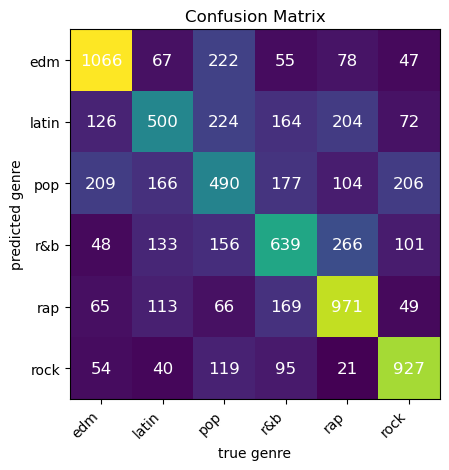

In [20]:
# Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Encore une fois, les gens les mieux prédits sont edm, rap et rock et les moins bien prédits sont latin pop et r&b

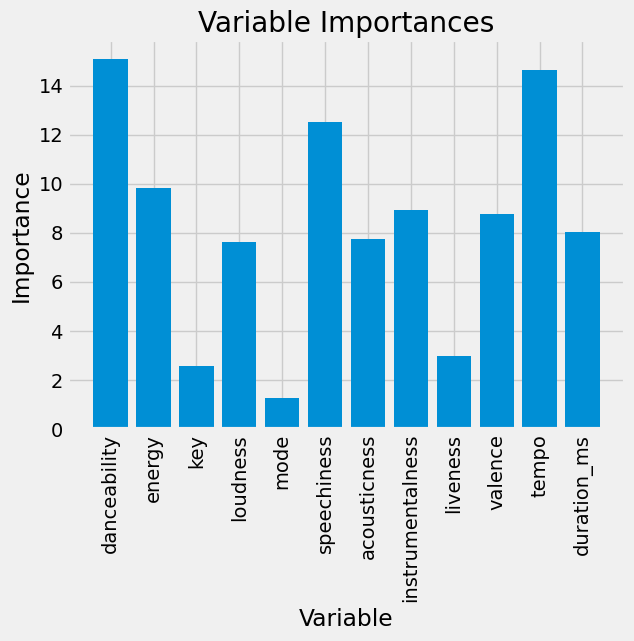

In [21]:
# Feature importances
plt.style.use('fivethirtyeight')

importances = list(model.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Nous observons un changement par rapport aux graphiques des deux modèles précédents. En effet, il semble que le modèle CatBoost s’appuie moins sur la variable "liveness" que les autres. Cependant, nous constatons toujours des similitudes, comme le fait que les variables "key" et "mode" n'ont que peu d’impact sur la prédiction du genre musical.  

De plus, notre modèle CatBoost nous permet de prédire un genre musical avec une précision de 56 %, ce qui est plutôt satisfaisant. Néanmoins, il garde les mêmes erreurs de prédiction sur latin, r&b et pop que les deux autres modèles

# Conclusion

Nous avons été en mesure de prédire le genre d'une musique à l'aide de quelques caractéristiques audio avec une précision de 56%. Ce résultat est encourageant au vu de la taille réduite de notre dataset d'entraînement.

Nous avons testé trois modèles : Random Forest, XGBoost et CatBoost, qui ont tous donné des résultats similaires et globalement satisfaisants. Néanmoins, le coût temporel et spatial diffère fortement selon ces modèles. En effet, random forest occupe un espace et demande des calculs beaucoup plus importants que les deux autres. Ces approches seraient donc celles à prioriser.

Une piste d'amélioration serait une meilleure prédiction des genres pop et R&B. Cependant, le principal défi de notre projet semble résider dans le fait que l'attribution d'un genre musical est intrinsèquement subjective, ce qui se reflète dans les caractéristiques communes des genres comme le pop et le R&B.